**12 October 2020**

# Dimension reduction, feature selection, normalization

## Admin

* Problem set 6 due Tuesday night by 11:59pm
* No class meeting, no reading, no response post for Wednesday. Enjoy fall break!
* Problem set 7 available later today, due a week from Tuesday (10/20).
* PS 8 coming soon. The task will be to explore the corpus built in PS 7, offering a hypothesis, experiments, and reflection on your findings.
    * Start thinking now about what you'd like to do
        * Desired outcomes shape corpus curation and metadata selection
    * Solo or in a group of no more than 3 students.
    * Expectations scaled to group size.

## Revisit classification algorithms

See notes from last week ...

## Normalization (*z*-scores)

* Even when we normalize our vectors, distances and similarities are dominated by common terms
    * Common terms contribute most of the weight to the overall vector
    * This might be what we want ...
    * ... or it might not.
* What if we care about the comparative usage rates of each included feature (word)?
    * That is, what if every word should contribute equally?
    * We could scale between, say, 0 and 1
        * But then we're at the mercy of high and low outliers
    * Instead, we often scale to mean zero and standard deviation one.
        * This is called a "standard score" or "*z*-score."
    
Consider:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances

sample = [
    [10,11,11,12],
    [0,0,1,1],
    [0,5,7,10]
]
df = pd.DataFrame(sample).T
df.columns = ['the', 'cat', 'she']

print('raw features:')
display(df)
print("raw mean:", round(np.mean(df.to_numpy()),2))
print('raw distances:')
display(pd.DataFrame(euclidean_distances(df)).mask(lambda x: x==0,np.nan).style.background_gradient(cmap='RdYlGn', axis=None))

print('\n\nmin-max scaling:')
minmax = MinMaxScaler().fit_transform(df)
display(minmax)
print("min-max mean:", round(np.mean(minmax),3))
print('min-max distances:')
display(pd.DataFrame(euclidean_distances(minmax)).mask(lambda x: x==0,np.nan).style.background_gradient(cmap='RdYlGn', axis=None))

print('\n\nz-scores:')
zscores = StandardScaler().fit_transform(df)
display(zscores)
print('z-score mean:', round(np.mean(zscores),3))
print('z-score distances:')
display(pd.DataFrame(euclidean_distances(zscores)).mask(lambda x: x==0,np.nan).style.background_gradient(cmap='RdYlGn', axis=None))

raw features:


,the,cat,she
0,10,0,0
1,11,0,5
2,11,1,7
3,12,1,10


raw mean: 5.67
raw distances:


,0,1,2,3
0,nan,5.099020,7.141428,10.246951
1,5.099020,nan,2.236068,5.196152
2,7.141428,2.236068,nan,3.162278
3,10.246951,5.196152,3.162278,nan




min-max scaling:


array([[0. , 0. , 0. ],
       [0.5, 0. , 0.5],
       [0.5, 1. , 0.7],
       [1. , 1. , 1. ]])

min-max mean: 0.517
min-max distances:


,0,1,2,3
0,nan,0.707107,1.319091,1.732051
1,0.707107,nan,1.019804,1.224745
2,1.319091,1.019804,nan,0.583095
3,1.732051,1.224745,0.583095,nan




z-scores:


array([[-1.41421356, -1.        , -1.5109662 ],
       [ 0.        , -1.        , -0.13736056],
       [ 0.        ,  1.        ,  0.41208169],
       [ 1.41421356,  1.        ,  1.23624508]])

z-score mean: 0.0
z-score distances:


,0,1,2,3
0,nan,1.971495,3.114179,4.421218
1,1.971495,nan,2.074099,2.808343
2,3.114179,2.074099,nan,1.636840
3,4.421218,2.808343,1.636840,nan


**You almost certainly want to normalize your feature data, probably with *z*-scores unless there's a good reason to do otherwise.**

## Dimension reduction

### The curse of dimensionality

* Low density of samples
    * Hard to identify "typical" or "average" points. 
    * Everything is an outlier.
    * All points are far apart (or have low similarity, or are uncorrelated).
* Multicolinearity
    * Always true when you have more dimensions than samples.
    * Many variables might be substituted for one another.
    * But *which ones*?
    * This is a problem if we want to *interpret* our model.
* Overfitting
    * Too much "detail" in our training data.
    * For example, say we care about cats in our texts.
        * Do we need features `['cat', 'cats', 'kitten', 'kittens', 'kitty', 'kitties', 'Cat', 'Cats', ...]`?
        * Probably not; any one of these, or their sum, would do.

The trick, then, is to figure out *which* features to keep (feature selection) and/or how collapse multiple features into one (dimension reduction).

Note that this explains why the Decision Tree classifier with a shallow tree depth performed well in the current problem set: it effectively performs dimension reduction via feature selection.

### Feature selection

We'll talk more about this later, but for now, a few key points:

* If a feature has the same value for most objects (that is, it has low variance), it is unlikely to be informative and is a good candidate for elimination.
* We're looking to hold on to as much of the underlying variance (information) in the data as possible, while eliminating as many features as possible.
    * Any measure of correlation or mutual information would help us identify features that provide similar information.
    * We might then drop one or more of those variables with little loss of overall information.
* We can also work empirically and *post hoc* by calculating feature importances from our classifier (where possible).
    * We then retain only the *n* most important features and examine the impact on classifier performance.


### Linear and manifold methods

But we can also *transform* our features, rather than just dropping some and retaining others.

Specifically, we can look for mathematical *combinations* of features that hold on to all or most of the underlying variance.

Consider:

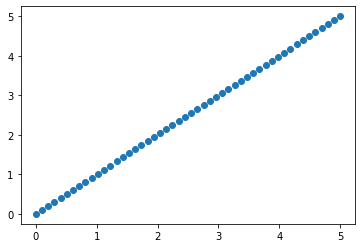

In [2]:
# linearly related variables
x = np.linspace(0,5)
y = x

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(x,y);

* If we know *x*, we already know the *exact* value of *y*!
* Here, we could just drop *x* or *y*.

But what about this case?:

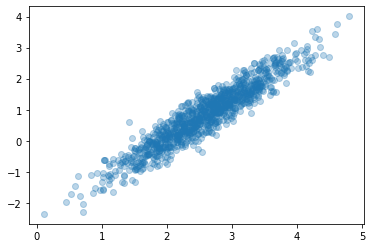

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=1)
transformation = [[-0.6, -0.6], [0.4, 0.8]]
X_aniso = np.dot(X, transformation)
plt.scatter(X_aniso[:,0], X_aniso[:,1], alpha=0.3);

#### Principal component analysis (PCA)

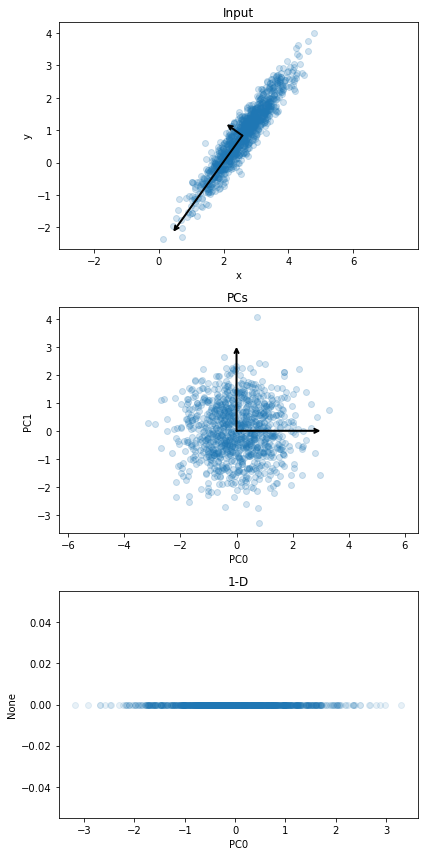

Explained variance: [0.97392416 0.02607584]


In [8]:
from sklearn.decomposition import PCA

# A function to draw vectors
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# Set up and fit PCA
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X_aniso)

# Plotting
fig, ax = plt.subplots(3,1, figsize=(6, 12))

# Input data
ax[0].scatter(X_aniso[:, 0], X_aniso[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='Input')

# PCA 2-D
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='PC0', ylabel='PC1',
          title='PCs')

# PCA 1-D
ax[2].scatter(X_pca[:,0], np.zeros(shape=len(X_aniso)), alpha=0.1)
ax[2].set(xlabel='PC0', ylabel='None', title='1-D')

plt.tight_layout()
plt.show()

print("Explained variance:", pca.explained_variance_ratio_)

#### Truncated SVD

Singular Value Decomposition (SVD) is closely related to PCA. The only difference, from our perspective, is that, because PCA needs to standardize input data, it requires dense (rather than sparse) input. So, we use SVD (via `TrunctedSVD`) when we want to preserve input sparsity (e.g., when our dataset is very large). "Truncated" just means that we retain fewer dimensions in our output than existed in the input.

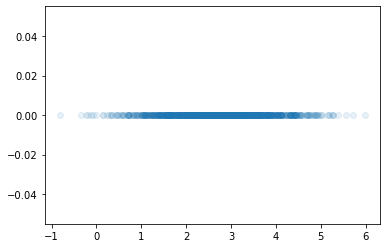

Explained variance: 0.7164
Explained variance using standardized data: 0.9712


In [6]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1)
X = svd.fit_transform(X_aniso)
plt.scatter(X[:,0], np.zeros(shape=len(X)), alpha=0.1)
plt.show()
print('Explained variance:', round(svd.explained_variance_ratio_[0],4))
svd.fit_transform(StandardScaler().fit_transform(X_aniso))
print('Explained variance using standardized data:', round(svd.explained_variance_ratio_[0],4))

Notes:

* Standardizing our input data captures almost the same amount of variance as does PCA
* We've used a one-dimensional plot here *not* because SVD is doing something different from PCA, but to show what dimension *reduction* looks like. We had 2-D inputs; it doesn't really make sense to use 2-D outputs!

#### *t*-SNE

*t*-distributed Stochastic Neighbor Embedding is a *manifold* method. Features are projected into a multidimensional manifold rather than onto lines.

TSNE is widely used for visualization, because it's good at maintaining internal structure ("lumpiness").

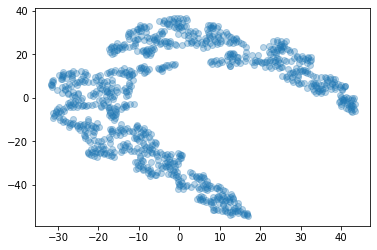

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE()
X = tsne.fit_transform(X_aniso)
plt.scatter(X[:,0], X[:,1], alpha=0.3);